In [19]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path
import gc
import os

In [21]:
process_type='inter'

species='human'
SRP_name='aggregates'
resolution='10kbp_raw'

In [22]:
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/hic_gene_{process_type}_none_by_allbins_top1.h5', 'r') as hf:
    my_data = hf['matrix'][:]
    gene_list = hf['gene_list'][:]

    bins_bed = hf['bins_bed'][:]

In [588]:
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/hic_gene_{process_type}_none_by_allbins_top1.h5', 'r') as hf:

    gene_list = hf['gene_list'][:]

    bins_bed = hf['bins_bed'][:]

In [566]:
bins_bed 

array([     0,      1,      2, ..., 287506, 287507, 287508])

In [596]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'type']

number_of_genes_list = [300]
marker_level_list = ['subclass']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

        marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin([x.decode() for x in gene_list])]
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

In [597]:
if marker_level == 'type':

    marker_list_t = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

    marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

    marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
    marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


    marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type']].merge(marker_list_t[['classt', 'group']])
    
if marker_level == 'subclass':
    marker_list.rename(columns = {'group':'classt'}, inplace = True)
    marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
    marker_list['cell_type'] = marker_list['group'].tolist()
    
if marker_level == 'class':
    #marker_list.rename(columns = {'group':'classt'}, inplace = True)
    #marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
    marker_list['group'] = marker_list['cell_type'].tolist()
    marker_list['classt'] = marker_list['cell_type'].tolist()
    #marker_list['cell_type'] = marker_list['Ensembl_gene_identifier'].tolist()
    
    

In [598]:
marker_list = marker_list.sample(frac=1)

marker_list = marker_list[['classt', 'group', 'cell_type', 'Ensembl_gene_identifier']]

In [599]:
df_gene_tp = pd.DataFrame(my_data ,  index=[x.decode() for x in gene_list.tolist()], columns = bins_bed.tolist())


df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

#df_gene_tp = df_gene_tp.fillna(0)

In [600]:
df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])

df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean()

In [601]:
all_bins_mean = df_gene_tp_all_info_mean.mean(axis=0)

all_bins_std = df_gene_tp_all_info_mean.std(axis=0)

In [584]:
    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    #os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/hba.whole.union.peaks.bed -a /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_try.bed")
    #os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect  -wb -a /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/hba.whole.union.peaks.bed -b /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_try_oppo.bed")
    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect  -wb -a /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/s10.txt -b /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed")
    #bins_bed_cre = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_try.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')
    


0

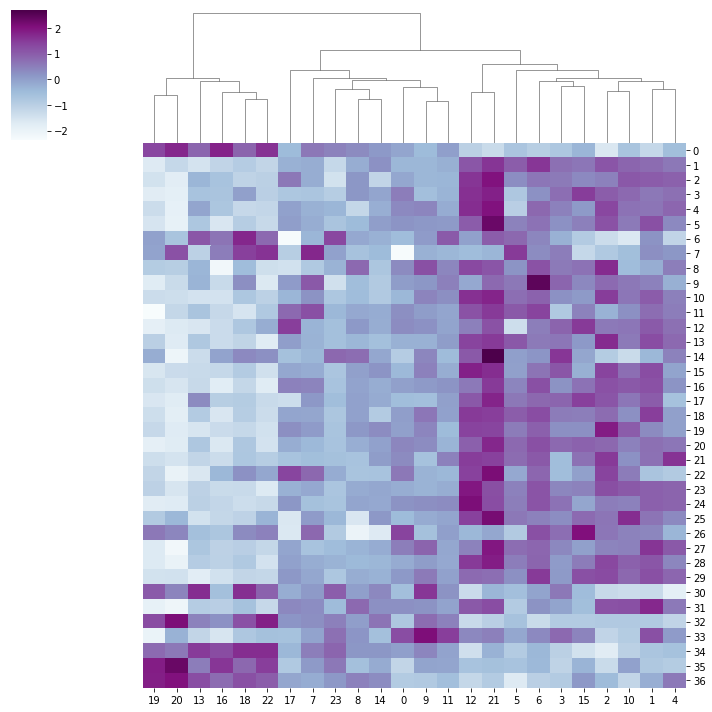

In [602]:
df_hba_modules = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_modules.bed', sep='\t', names=['c','d', 'e', 'f', 'ccre', 'chr', 'start', 'end', 'bin_id'])


df_hba_modules = df_hba_modules.drop_duplicates(['bin_id'], keep=False)

mean_list = []
for i in list(range(1,38)):
    m="M"+str(i)
    given_bins = df_hba_modules[df_hba_modules['ccre']==m]['bin_id'].tolist()
    mean_list.append(df_gene_tp_all_info_mean.loc[:, given_bins].mean(axis=1).values.tolist())
    
sns.clustermap(np.vstack(mean_list), cmap="BuPu", col_cluster=True, row_cluster=False, robust=False, z_score=0)


In [575]:
df_gene_tp_all_info_mean

0         1       2         3       \
classt        group      cell_type                                        
GABAergic     Chandelier Chandelier     0.0  0.009009     0.0  0.009009   
              Lamp5      Lamp5          0.0  0.000000     0.0  0.000000   
              Lamp5_Lhx6 Lamp5_Lhx6     0.0  0.000000     0.0  0.000000   
              Pax6       Pax6           0.0  0.009009     0.0  0.000000   
              Pvalb      Pvalb          0.0  0.024194     0.0  0.000000   
              Sncg       Sncg           0.0  0.000000     0.0  0.000000   
              Sst        Sst            0.0  0.008850     0.0  0.008850   
              Sst Chodl  Sst Chodl      0.0  0.008065     0.0  0.000000   
              Vip        Vip            0.0  0.000000     0.0  0.000000   
Glutamatergic L2/3 IT    L2/3 IT        0.0  0.000000     0.0  0.000000   
              L4 IT      L4 IT          0.0  0.000000     0.0  0.000000   
              L5 ET      L5 ET          0.0  0.008264     0.0  0.008264   
              L5 IT      L5 IT          0.0  0.009524     0.0  0.009524   
              L5/6 NP    L5/6 NP        0.0  0.000000     0.0  0.000000   
              L6 CT      L6 CT          0.0  0.000000     0.0  0.000000   
              L6 IT      L6 IT          0.0  0.008850     0.0  0.000000   
              L6 IT Car3 L6 IT Car3     0.0  0.007407     0.0  0.000000   
              L6b        L6b            0.0  0.000000     0.0  0.000000   
Non-neuronal  Astro      Astro          0.0  0.005405     0.0  0.005405   
              Endo       Endo           0.0  0.010695     0.0  0.000000   
              Micro-PVM  Micro-PVM      0.0  0.004975     0.0  0.004975   
              OPC        OPC            0.0  0.000000     0.0  0.000000   
              Oligo      Oligo          0.0  0.009615     0.0  0.004808   
              VLMC       VLMC           0.0  0.019108     0.0  0.012739   

                                       4         5         6         7       \
classt        group      cell_type                                            
GABAergic     Chandelier Chandelier  0.009009  0.018018  0.018018  0.018018   
              Lamp5      Lamp5       0.000000  0.000000  0.000000  0.000000   
              Lamp5_Lhx6 Lamp5_Lhx6  0.000000  0.000000  0.000000  0.000000   
              Pax6       Pax6        0.000000  0.009009  0.009009  0.009009   
              Pvalb      Pvalb       0.000000  0.016129  0.016129  0.008065   
              Sncg       Sncg        0.000000  0.010101  0.020202  0.000000   
              Sst        Sst         0.000000  0.017699  0.017699  0.017699   
              Sst Chodl  Sst Chodl   0.000000  0.000000  0.000000  0.000000   
              Vip        Vip         0.000000  0.027027  0.000000  0.000000   
Glutamatergic L2/3 IT    L2/3 IT     0.000000  0.000000  0.017544  0.000000   
              L4 IT      L4 IT       0.000000  0.000000  0.000000  0.008000   
              L5 ET      L5 ET       0.008264  0.033058  0.016529  0.016529   
              L5 IT      L5 IT       0.000000  0.009524  0.019048  0.009524   
              L5/6 NP    L5/6 NP     0.000000  0.024000  0.032000  0.024000   
              L6 CT      L6 CT       0.000000  0.000000  0.000000  0.000000   
              L6 IT      L6 IT       0.000000  0.000000  0.000000  0.000000   
              L6 IT Car3 L6 IT Car3  0.000000  0.022222  0.029630  0.000000   
              L6b        L6b         0.000000  0.011364  0.000000  0.000000   
Non-neuronal  Astro      Astro       0.005405  0.021622  0.016216  0.010811   
              Endo       Endo        0.005348  0.021390  0.016043  0.010695   
              Micro-PVM  Micro-PVM   0.000000  0.004975  0.004975  0.000000   
              OPC        OPC         0.000000  0.014706  0.000000  0.000000   
              Oligo      Oligo       0.004808  0.019231  0.019231  0.009615   
              VLMC       VLMC        0.000000  0.050955  0.031847  0.019108   

                               

In [467]:


    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bede = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bede['bin_id'] = bins_bede.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bede.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')

In [531]:
gi = list(set.intersection(set(bins_bed_cre[bins_bed_cre['cre'] >= 14]['bin_id'].tolist()), (set( all_bins_std[all_bins_std >= 0.06].index.tolist()))) )


In [532]:
len(gi)

10

In [412]:
all_bins_std.max()

0.07743000984191895

In [405]:
all_bins_mean.max()

1.0

In [318]:
%matplotlib inline
import seaborn as sns
import random
bin_random = random.sample(range(287509), 1000)

In [547]:
df_gene_tp_all_info_mean

0         1         2         3       \
classt        group      cell_type                                          
GABAergic     Chandelier Chandelier     0.0  0.004545  0.000000  0.004545   
              Lamp5      Lamp5          0.0  0.000000  0.000000  0.000000   
              Lamp5_Lhx6 Lamp5_Lhx6     0.0  0.000000  0.000000  0.000000   
              Pax6       Pax6           0.0  0.016461  0.000000  0.000000   
              Pvalb      Pvalb          0.0  0.015267  0.000000  0.000000   
              Sncg       Sncg           0.0  0.005814  0.000000  0.000000   
              Sst        Sst            0.0  0.004785  0.000000  0.004785   
              Sst Chodl  Sst Chodl      0.0  0.007435  0.000000  0.000000   
              Vip        Vip            0.0  0.000000  0.000000  0.000000   
Glutamatergic L2/3 IT    L2/3 IT        0.0  0.004831  0.000000  0.004831   
              L4 IT      L4 IT          0.0  0.000000  0.000000  0.000000   
              L5 ET      L5 ET          0.0  0.008547  0.000000  0.008547   
              L5 IT      L5 IT          0.0  0.010101  0.000000  0.005051   
              L5/6 NP    L5/6 NP        0.0  0.006369  0.000000  0.000000   
              L6 CT      L6 CT          0.0  0.007353  0.000000  0.000000   
              L6 IT      L6 IT          0.0  0.009050  0.000000  0.000000   
              L6 IT Car3 L6 IT Car3     0.0  0.008000  0.004000  0.004000   
              L6b        L6b            0.0  0.000000  0.000000  0.000000   
Non-neuronal  Astro      Astro          0.0  0.007752  0.000000  0.002584   
              Endo       Endo           0.0  0.020151  0.002519  0.012594   
              Micro-PVM  Micro-PVM      0.0  0.004619  0.000000  0.002309   
              OPC        OPC            0.0  0.004717  0.000000  0.004717   
              Oligo      Oligo          0.0  0.005038  0.000000  0.002519   
              VLMC       VLMC           0.0  0.010638  0.002660  0.007979   

                                       4         5         6         7       \
classt        group      cell_type                                            
GABAergic     Chandelier Chandelier  0.004545  0.013636  0.013636  0.013636   
              Lamp5      Lamp5       0.000000  0.004785  0.000000  0.000000   
              Lamp5_Lhx6 Lamp5_Lhx6  0.000000  0.000000  0.000000  0.005882   
              Pax6       Pax6        0.000000  0.020576  0.016461  0.004115   
              Pvalb      Pvalb       0.000000  0.011450  0.015267  0.007634   
              Sncg       Sncg        0.000000  0.011628  0.011628  0.000000   
              Sst        Sst         0.000000  0.019139  0.019139  0.009569   
              Sst Chodl  Sst Chodl   0.000000  0.003717  0.003717  0.000000   
              Vip        Vip         0.000000  0.020202  0.000000  0.000000   
Glutamatergic L2/3 IT    L2/3 IT     0.004831  0.004831  0.014493  0.004831   
              L4 IT      L4 IT       0.004065  0.008130  0.004065  0.008130   
              L5 ET      L5 ET       0.004274  0.029915  0.021368  0.012821   
              L5 IT      L5 IT       0.000000  0.020202  0.025253  0.005051   
              L5/6 NP    L5/6 NP     0.000000  0.025478  0.031847  0.019108   
              L6 CT      L6 CT       0.000000  0.007353  0.000000  0.000000   
              L6 IT      L6 IT       0.000000  0.000000  0.004525  0.000000   
              L6 IT Car3 L6 IT Car3  0.000000  0.024000  0.020000  0.000000   
              L6b        L6b         0.000000  0.008475  0.000000  0.000000   
Non-neuronal  Astro      Astro       0.005168  0.018088  0.020672  0.012920   
              Endo       Endo        0.012594  0.030227  0.025189  0.022670   
              Micro-PVM  Micro-PVM   0.002309  0.006928  0.011547  0.002309   
              OPC        OPC         0.000000  0.018868  0.004717  0.004717   
              Oligo      Oligo       0.002519  0.017632  0.022670  0.010076   
              VLMC       VLMC        0.002660  0.031915  0.

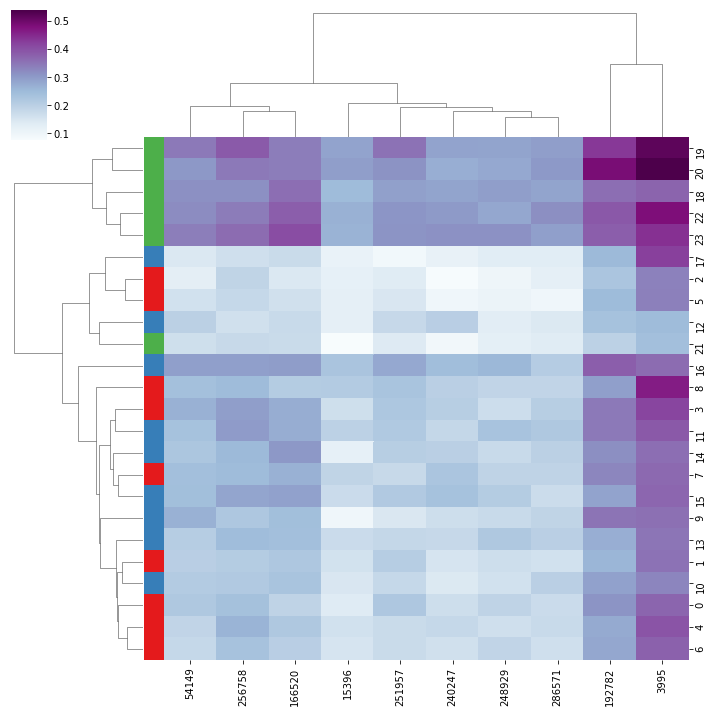

In [533]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('group').drop_duplicates(), sns.color_palette("Paired", df_gene_tp_all_info_mean.index.get_level_values('group').shape[0]).as_hex()[:]))
row_colors2 =df_gene_tp_all_info_mean.index.get_level_values('group').map(lut)
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[(all_bins_std >= 0.06) & (all_bins_mean >= 0.0)].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
sns.clustermap(df_gene_tp_all_info_mean.loc[:, gi].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 14]['bin_id'].tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, bin_random].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])


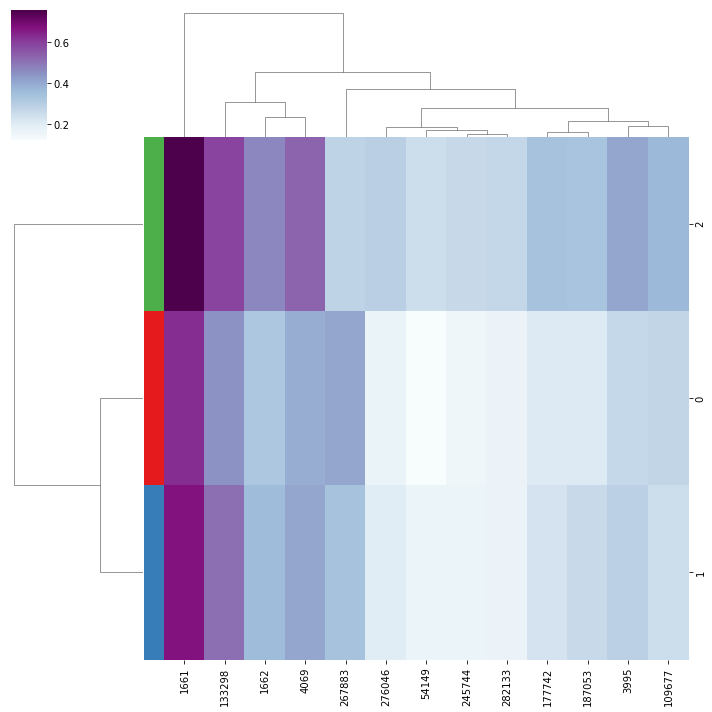

In [455]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('group').drop_duplicates(), sns.color_palette("Paired", df_gene_tp_all_info_mean.index.get_level_values('group').shape[0]).as_hex()[:]))
row_colors2 =df_gene_tp_all_info_mean.index.get_level_values('group').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[(all_bins_std >= 0.06) & (all_bins_mean >= 0.0)].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 14]['bin_id'].tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, bin_random].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])

In [456]:
df_gene_tp_all_info_mean.loc[:, all_bins_std[(all_bins_std >= 0.06) & (all_bins_mean >= 0.0)].index.tolist()].columns

Int64Index([  1661,   1662,   3995,   4069,  54149, 109677, 133298, 177742,
            187053, 245744, 267883, 276046, 282133],
           dtype='int64')

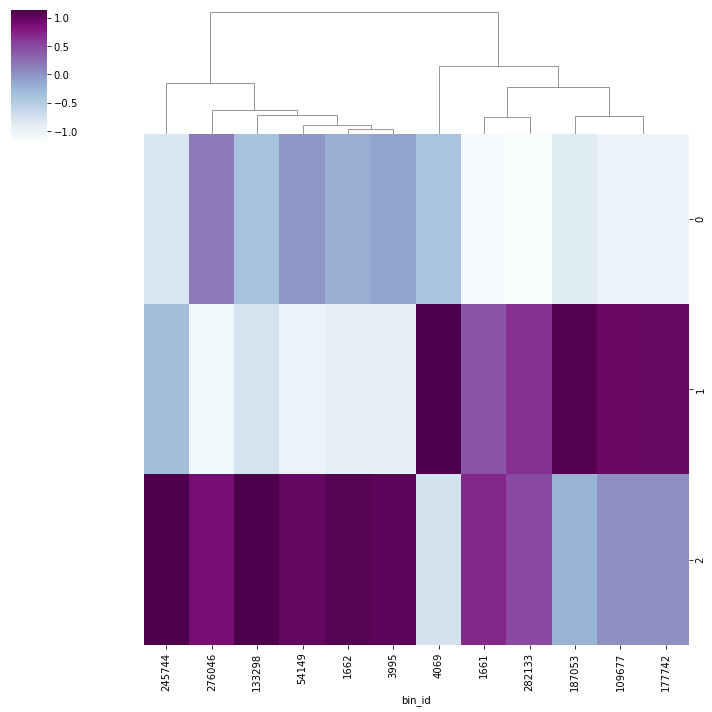

In [545]:
sns.clustermap(df_exp_tp_w_zcore[[1661,   1662,   3995,   4069,  54149, 109677, 133298, 177742,187053, 245744, 276046, 282133]], cmap="BuPu", row_cluster=False, robust=False, z_score=1)




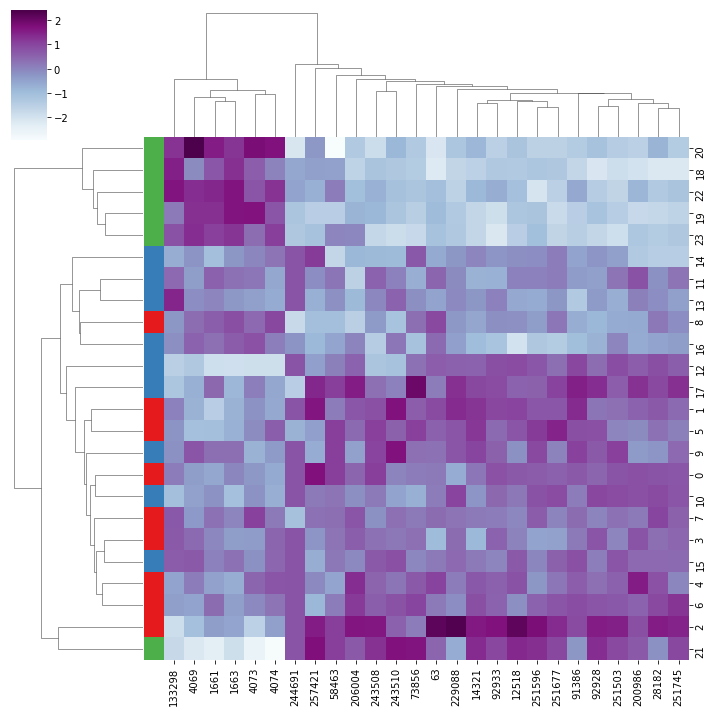

In [349]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('group').drop_duplicates(), sns.color_palette("Paired", df_gene_tp_all_info_mean.index.get_level_values('group').shape[0]).as_hex()[:]))
row_colors2 =df_gene_tp_all_info_mean.index.get_level_values('group').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[(all_bins_std >= 0.003) & (all_bins_mean >= 0.5)].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors], z_score=1)
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 14]['bin_id'].tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, bin_random].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])


In [418]:
[[133298, 4069, 1661, 1663, 4073, 4074]]

0       1       2       3       4       5       6       \
ENSG00000173786     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
ENSG00000169064     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
ENSG00000163453     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
ENSG00000197584     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
ENSG00000149654     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...                 ...     ...     ...     ...     ...     ...     ...   
ENSG00000145703     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
ENSG00000159164     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ENSG00000166091     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
ENSG00000170381     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
ENSG00000148400     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

                 7       8       9       ...  287499  287500  287501  287502  \
ENSG00000173786     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
ENSG00000169064     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
ENSG00000163453     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
ENSG00000197584     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
ENSG00000149654     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
...                 ...     ...     ...  ...     ...     ...     ...     ...   
ENSG00000145703     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
ENSG00000159164     NaN     NaN     NaN  ...     0.0     0.0     0.0     0.0   
ENSG00000166091     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
ENSG00000170381     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
ENSG00000148400     0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   

                 287503  287504  287505  287506  287507  287508  
ENSG00000173786     0.0     0.0     0.0     0.0     0.0     0.0  
ENSG00000169064     0.0     0.0     0.0     0.0     0.0     0.0  
ENSG00000163453     0.0     0.0     0.0     0.0     0.0     0.0  
ENSG00000197584     0.0     0.0     0.0     0.0     0.0     0.0  
ENSG00000149654     0.0     0.0     0.0     0.0     0.0     0.0  
...                 ...     ...     ...     ...     ...     ...  
ENSG00000145703     0.0     0.0     0.0     0.0     0.0     0.0  
ENSG00000159164     0.0     0.0     0.0     0.0     0.0     0.0  
ENSG00000166091     0.0     0.0     0.0     0.0     0.0     0.0  
ENSG00000170381     0.0     0.0     0.0     0.0     0.0     0.0  
ENSG00000148400     0.0     0.0     0.0     0.0     0.0     0.0  

[1466 rows x 287509 columns]

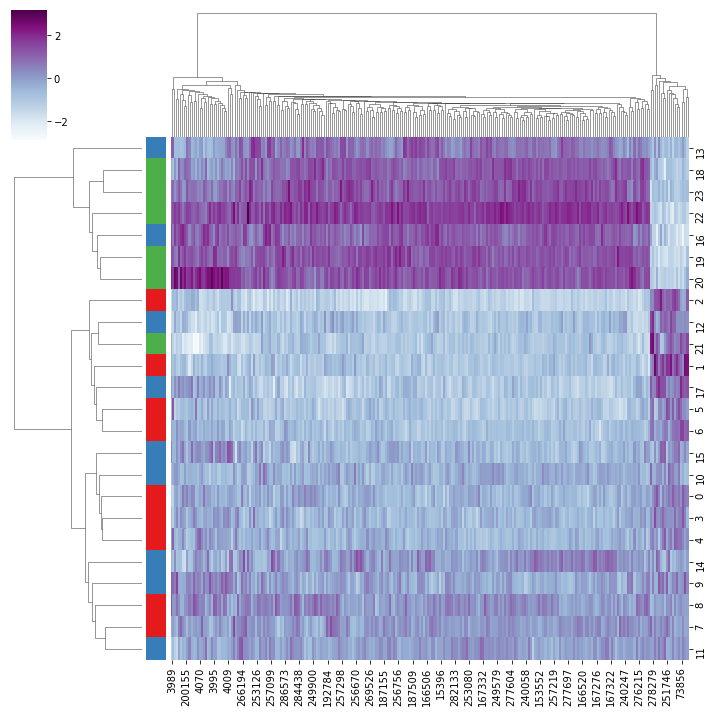

In [285]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('group').drop_duplicates(), sns.color_palette("Paired", df_gene_tp_all_info_mean.index.get_level_values('group').shape[0]).as_hex()[:]))
row_colors2 =df_gene_tp_all_info_mean.index.get_level_values('group').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[(all_bins_std >= 0.05) & (all_bins_mean >= 0.1)].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors], z_score=1)
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 14]['bin_id'].tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])
#sns.clustermap(df_gene_tp_all_info_mean.loc[:, bin_random].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=[row_colors])


In [25]:
df_gene_tp_all_info_mean

0    1    2    3    4    5    6    7  \
classt        group      cell_type                                            
GABAergic     Chandelier Chandelier  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              Lamp5      Lamp5       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              Lamp5_Lhx6 Lamp5_Lhx6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              Pax6       Pax6        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              Pvalb      Pvalb       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              Sncg       Sncg        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              Sst        Sst         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              Sst Chodl  Sst Chodl   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              Vip        Vip         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Glutamatergic L2/3 IT    L2/3 IT     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              L4 IT      L4 IT       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              L5 ET      L5 ET       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              L5 IT      L5 IT       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              L5/6 NP    L5/6 NP     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              L6 CT      L6 CT       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              L6 IT      L6 IT       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              L6 IT Car3 L6 IT Car3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              L6b        L6b         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Non-neuronal  Astro      Astro       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              Endo       Endo        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              Micro-PVM  Micro-PVM   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              OPC        OPC         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              Oligo      Oligo       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
              VLMC       VLMC        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                       8    9  ...    recall  population_size  \
classt        group      cell_type             ...                              
GABAergic     Chandelier Chandelier  0.0  0.0  ...  0.764440        80.888889   
              Lamp5      Lamp5       0.0  0.0  ...  0.713841       442.222222   
              Lamp5_Lhx6 Lamp5_Lhx6  0.0  0.0  ...  0.723789       283.777778   
              Pax6       Pax6        0.0  0.0  ...  0.627095        93.777778   
              Pvalb      Pvalb       0.0  0.0  ...  0.643458      1314.333333   
              Sncg       Sncg        0.0  0.0  ...  0.571315       258.750000   
              Sst        Sst         0.0  0.0  ...  0.585048      1502.555556   
              Sst Chodl  Sst Chodl   0.0  0.0  ...  0.755347        21.375000   
              Vip        Vip         0.0  0.0  ...  0.579808      1135.444444   
Glutamatergic L2/3 IT    L2/3 IT     0.0  0.0  ...  0.446723      3858.222222   
              L4 IT      L4 IT       0.0  0.0  ...  0.556061      1865.444444   
              L5 ET      L5 ET       0.0  0.0  ...  0.842232        52.444444   
              L5 IT      L5 IT       0.0  0.0  ...  0.634734      2410.666667   
              L5/6 NP    L5/6 NP     0.0  0.0  ...  0.818702       397.666667   
              L6 CT      L6 CT       0.0  0.0  ...  0.618431       352.000000   
              L6 IT      L6 IT       0.0  0.0  ...  0.713569       833.444444   
              L6 IT Car3 L6 IT Car3  0.0  0.0  ...  0.787946       542.111111   
              L6b        L6b         0.0  0.0  ...  0.743405       395.000000   
Non-neuronal  Astro      Astro       0.0  0.0  ...  0.893680       380.875000   
              Endo       Endo        0.0  0.0  ...  0.824231        20.888889   
              Micro-PVM  Micro-PVM   0.0  0.0  ...  0.765382       140.333333   
              OPC        OPC         0.0  0.0  ...  0.937470       265.777778   
              Oligo      Oligo       0.0

In [188]:


    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bede = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bede['bin_id'] = bins_bede.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bede.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')

In [423]:
bins_bed_cre[bins_bed_cre['bin_id'] == 1661]

chr     start       end  bin_id  cre
1661  chr1  16610000  16620000    1661   11

In [421]:
bins_bede[bins_bede['bin_id'] == 1661]

chr     start       end  bin_id
1661  chr1  16610000  16620000    1661

In [546]:
 
'Glutamatergic' : 'Glutamatergic',
'GABAergic' : 'GABAergic',
'Non-neuronal' : 'Non-neuronal'          
}

#cell_type_map = {

#'Glutamatergic' : 'Glutamatergic',
#'GABAergic' : 'GABAergic',
#'Non-neuronal' : 'Non-neuronal'          
#}

class_map = {'ITL23' : 'Glutamatergic' ,
'ITL4' : 'Glutamatergic' ,
'ITL5' : 'Glutamatergic' ,
'ITL6_1' : 'Glutamatergic' ,
'ITL6_2' : 'Glutamatergic' ,
'CT' : 'Glutamatergic' ,
'L6B' : 'Glutamatergic' ,
'NP' : 'Glutamatergic' ,
'ET' : 'Glutamatergic' ,
'SST_CHODL' : 'GABAergic' ,
'SST' : 'GABAergic' ,
'PVALB' : 'GABAergic' ,
'PV_ChCs' : 'GABAergic' ,
'VIP' : 'GABAergic' ,
'SNCG' : 'GABAergic' ,
'LAMP5' : 'GABAergic' ,
'LAMP5_LHX6' : 'GABAergic' ,
'ASCT' : 'ASTRO' ,
'MGC' : 'Non-neuronal' ,
'OPC' : 'Non-neuronal' ,
'OGC' : 'Non-neuronal' ,
'EC' : 'Non-neuronal' , }

class_types = ['Glutamatergic', 'GABAergic', 'Non-neuronal']

input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/'
bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
bins_bed['bin_id'] = bins_bed.index
bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')

df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/Table S6 – List of cCREs in bed format', sep='\t', names=['chr', 'start', 'end', 'cCRE_name'])
#df_cre = df_cre[df_cre['chr'].isin(chr_list)]
df_cre['start_bin'] = df_cre['start']/10000
df_cre['start_bin'] = df_cre['start_bin'].astype('int')
df_cre['start_bin'] = df_cre['start_bin']*10000
df_cre['start_bin'] = df_cre['start_bin'].astype('str')
df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
#df_cre_1kb = df_cre.drop_duplicates(subset=['start_bin'])

df_cre_1kb = df_cre.merge(bins_bed, left_on='start_bin', right_on='pos')

df_exp_list = []

for key in cell_type_map:

    df_exp = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/{key}.txt', names=['cCRE_name'])

    df_exp = df_exp.merge(df_cre_1kb)[['bin_id']]

    df_exp['tp'] = 1
    
    df_exp = df_exp.groupby(['bin_id'])['tp'].sum().reset_index()
    
    #print (df_exp)

    df_exp['tp'] = df_exp['tp']/df_exp['tp'].max()
    
    #df_exp = df_exp.drop_duplicates(subset=['bin_id'])

    df_exp = df_exp.set_index('bin_id').T
    
    df_exp['group'] = cell_type_map[key].lower()
    
    df_exp_list.append(df_exp)


df_exp_tp = pd.concat(df_exp_list)

df_exp_tp = df_exp_tp.fillna(0)


In [452]:
df_exp_tp[[133298, 4069, 1661, 1662, 4069, 4074]]

bin_id    133298    4069      1661      1662      4069      4074  
tp      0.076412  0.360465  0.267442  0.272425  0.360465  0.059801
tp      0.075330  0.363465  0.271186  0.265537  0.363465  0.060264
tp      0.082294  0.354115  0.271820  0.276808  0.354115  0.059850

In [535]:
df_exp_tp_w = df_exp_tp.drop(['group'], axis=1)

In [536]:
df_exp_tp_w_zcore = stats.zscore(df_exp_tp_w,axis=1, nan_policy='omit')  

In [539]:
df_exp_tp_w_zcore= pd.DataFrame(df_exp_tp_w_zcore , columns =df_exp_tp_w.columns)

In [543]:
df_exp_tp_w_zcore

bin_id    0         18        19        26       58        62        63      \
0      -0.877663 -0.743492 -0.810578 -1.052086 -1.17284 -0.743492 -0.703241   
1      -0.928115 -0.758123 -0.696307 -1.067200 -1.19083 -0.696307 -0.696307   
2      -0.863331 -0.719928 -0.719928 -1.006734 -1.12965 -0.719928 -0.699442   

bin_id    77        81        82      ...    287488    287489    287490  \
0       0.772641 -0.676407  0.088369  ... -0.743492  3.281641 -1.186257   
1       0.756354 -0.680853  0.045477  ... -0.758123  3.213516 -1.175377   
2       0.734588 -0.556039  0.079032  ... -0.822358  3.254383 -1.191109   

bin_id    287491    287492    287493    287505    287507    553       180433  
0       0.209123 -1.065503 -1.038669 -0.354396 -1.038669 -1.548519 -1.548519  
1       0.292739 -1.067200 -1.067200 -0.325415 -1.067200 -1.561723 -1.561723  
2       0.242921 -1.068192 -1.068192 -0.330691 -0.965761 -1.539373 -1.539373  

[3 rows x 206220 columns]

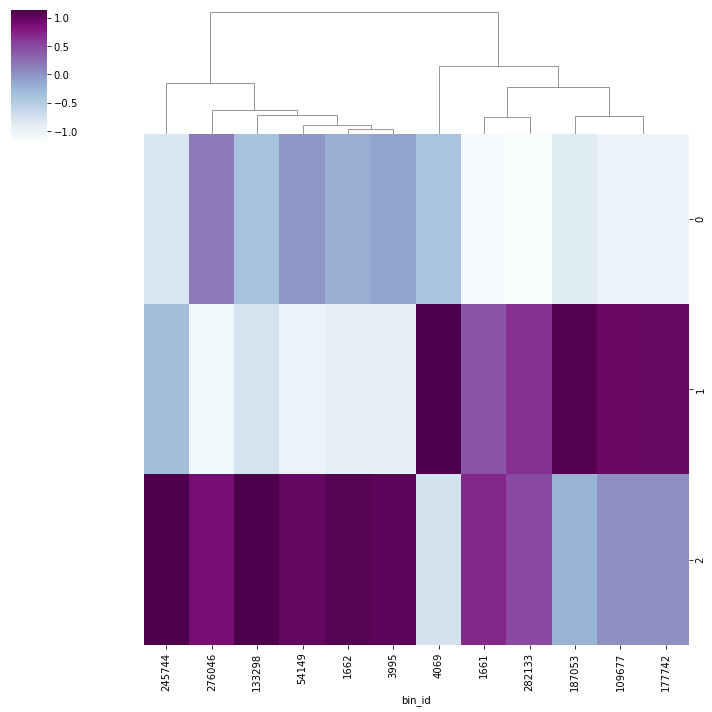

In [544]:

sns.clustermap(df_exp_tp_w_zcore[[1661,   1662,   3995,   4069,  54149, 109677, 133298, 177742,187053, 245744, 276046, 282133]], cmap="BuPu", row_cluster=False, robust=False, z_score=1)




In [540]:
df_exp_tp_w_zcore[[1661,   1662,   3995,   4069,  54149, 109677, 133298, 177742,187053, 245744, 276046, 282133]]

bin_id    1661      1662      3995      4069      54149     109677    133298  \
0       0.611636  0.651887  2.181438  1.362994  1.376411 -0.327562 -0.931332   
1       0.663631  0.617270  2.147201  1.420870  1.343601 -0.294507 -0.943569   
2       0.673130  0.714102  2.230076  1.349172  1.410631 -0.310205 -0.883817   

bin_id    177742    187053    245744    276046    282133  
0       3.040133  1.698422  1.886261  2.892544  0.088369  
1       3.136247  1.822670  1.899939  2.796262  0.122747  
2       3.090494  1.738409  1.943270  2.947091  0.120004

In [542]:
df_exp_tp_w_zcore[[133298, 4069, 1661, 1663, 4073, 4074]]

bin_id    133298    4069      1661      1663      4073      4074  
0      -0.931332  1.362994  0.611636 -0.448316 -0.931332 -1.065503
1      -0.943569  1.420870  0.663631 -0.433592 -0.928115 -1.067200
2      -0.883817  1.349172  0.673130 -0.433122 -0.904303 -1.068192

In [201]:
df_prior = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/totg_reg_prior_only_top1_inter.csv', sep='\t')
#del_al = int(df_prior.shape[0]*no_of_high_bins/100)
given_bins = df_prior.sort_values(by=['prior_val']).tail(86276)['bin_id'].tolist()
        

In [41]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#features = df.loc[:, :2875001]
#features = df_gene_tp.loc[:, :]
#features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >= 0.04].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features_sc)

In [42]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}
)


fig_2d.show()



In [202]:
all_bins_std.max()

0.16202285885810852

In [203]:
all_bins_std

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
2875007    0.0
2875008    0.0
2875009    0.0
2875010    0.0
2875011    0.0
Length: 2875012, dtype: float32

In [ ]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >= 0.05].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=row_colors)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



In [198]:
df_gene_tp_all_info_mean.max().max()

1.0

In [158]:


    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')

In [159]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)

In [162]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'classt'}, color_discrete_sequence=sns.color_palette("Spectral", df_proj_2d.group.drop_duplicates().shape[0]).as_hex()[:]
)


fig_2d.show()

In [134]:
df_prior = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/totg_reg_prior_only_top1_inter.csv', sep='\t')
#del_al = int(df_prior.shape[0]*no_of_high_bins/100)
given_bins = df_prior.sort_values(by=['prior_val']).tail(86276)['bin_id'].tolist()
        

In [135]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = df_gene_tp.loc[:, given_bins]


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)


In [140]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.cell_type, labels={'color': 'cell_type'}
)


fig_2d.show()

In [43]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.classt, labels={'color': 'classt'}
)


fig_2d.show()

In [53]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'group'}
)


fig_2d.show()

In [121]:
sns.color_palette("Paired", df_proj_2d.group.drop_duplicates().shape[0]).as_hex()[:]

['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928',
 '#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

In [124]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'group'}, color_discrete_sequence=sns.color_palette("Spectral", df_proj_2d.group.drop_duplicates().shape[0]).as_hex()[:]
)


fig_2d.show()



In [129]:
marker_list.group.head()

0    L6 CT
1    L6 CT
2    L6 CT
3    L6 CT
4    L6 CT
Name: group, dtype: object

In [127]:
fig_2d = px.scatter(
     x=df_proj_2d[0], y=df_proj_2d[1],
    color=df_proj_2d.group, labels={'color': 'group'}, color_discrete_sequence=sns.color_palette("Spectral", df_proj_2d.group.drop_duplicates().shape[0]).as_hex()[:]
)


fig_2d.show()


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



ValueError: 'color' kwarg must be an color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

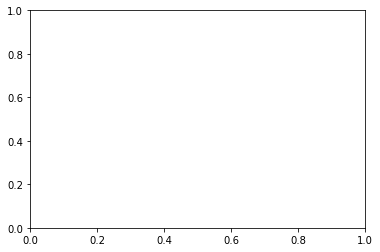

In [58]:
sns.scatterplot(proj_2d[:,0],proj_2d[:,1] , color=marker_list.group)

In [59]:
df_proj_2d= pd.DataFrame(proj_2d)

In [61]:
df_proj_2d['group'] = marker_list.group

In [62]:
df_proj_2d['cell_type'] = marker_list.cell_type

In [63]:
df_proj_2d['classt'] = marker_list.classt

In [72]:
df_proj_2d = df_proj_2d.sort_values(by=['classt', 'group', 'cell_type'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



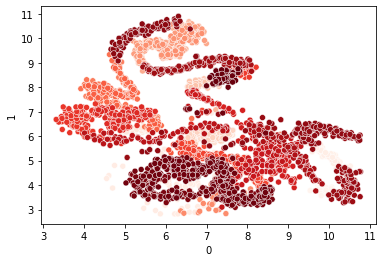

In [79]:
ax = sns.scatterplot(df_proj_2d[0], df_proj_2d[1] , hue=df_proj_2d.cell_type, legend=False, palette="Reds")

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



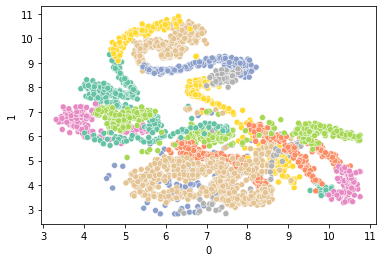

In [109]:
ax = sns.scatterplot(df_proj_2d[0], df_proj_2d[1] , hue=df_proj_2d.group, legend=False, palette=sns.color_palette("Set2", df_proj_2d.group.drop_duplicates().shape[0]))


In [111]:
color_palette("Set2", df_proj_2d.group.drop_duplicates().shape[0])

NameError: name 'color_palette' is not defined

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



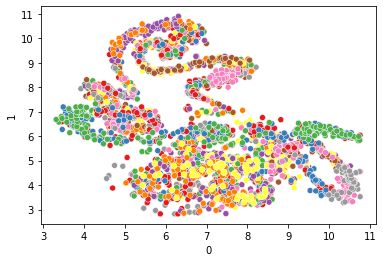

In [107]:
ax = sns.scatterplot(df_proj_2d[0], df_proj_2d[1] , hue=df_proj_2d.cell_type, legend=False, palette=sns.color_palette("Set1", df_proj_2d.cell_type.drop_duplicates().shape[0]))


In [98]:
df_proj_2d.group.drop_duplicates().shape[0]

24

In [83]:
sns.color_palette("hls", 20)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.5272, 0.33999999999999997),
 (0.86, 0.6832, 0.33999999999999997),
 (0.86, 0.8392000000000002, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.41279999999999994, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.42320000000000013),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.86, 0.7352000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.6727999999999997, 0.86),
 (0.33999999999999997, 0.5167999999999995, 0.86),
 (0.33999999999999997, 0.36079999999999973, 0.86),
 (0.4752000000000003, 0.33999999999999997, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.7767999999999993),
 (0.86, 0.33999999999999997, 0.6207999999999999),
 (0.86, 0.33999999999999997, 0.46479999999999977)]

In [84]:
sns.color_palette("Paired", 20)

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392),
 (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0)]

In [118]:
sns.color_palette("Set2",20).as_hex()[:]

['#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3']

In [113]:
y = sns.color_palette("Set2",20)

In [116]:
y.as_hex()[:]

['#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3']